# Lab 17

Today, we will begin exploring the idea of _ensemble methods_ or methods that are an aggregate of several machine learning methods. Today, we will: 

0. Explain aggregation in terms of ensemble methods 
1. Look at how random forests work in `sklearn`

In [1]:
## Import block
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import pandas as pd

from random import seed

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from six import StringIO

### Helper Functions
Before we switch to the `sklearn` implementation, we will build an example random forest out of our from-scratch decision trees. Open Lab 16 and paste your from-scratch decision tree code below (along with all helper functions). Alternately, you can put all your functions from Lab 16 in a `Lab16.py` file and `import Lab16` in the import block above.

In [2]:
# functions from Lab 16

def gini_index(data_pd: pd.DataFrame, class_var: str) -> float:
    """
    Given the observations of a binary class and the name of the binary class column
    calculate the gini index
    """
    # count classes 0 and 1
    count_A = np.sum(data_pd[class_var] == 0)
    count_B = np.sum(data_pd[class_var])

    # get the total observations
    n = count_A + count_B

    # If n is 0 then we return the lowest possible gini impurity
    if n == 0:
        return 0.0

    # Getting the probability to see each of the classes
    p1 = count_A / n
    p2 = count_B / n

    # Calculating gini
    gini = 1 - (p1 ** 2 + p2 ** 2)

    # Returning the gini impurity
    return gini

def info_gain(data_pd: pd.DataFrame, class_var: str, feature: str) -> float:
    """
    Calculates how much info we gain from a split compared to info at the current node
    """
    # compute the base gini impurity (at the current node)
    gini_base = gini_index(data_pd, class_var)

    # split on the feature
    node_left, node_right = split_bool(data_pd, feature)

    # count datapoints in each split and the whole dataset
    n_left = node_left.shape[0]
    n_right = node_left.shape[0]
    n = n_left + n_right

    # get left and right gini index
    gini_left = gini_index(node_left, class_var)
    gini_right = gini_index(node_right, class_var)

    # calculate weight for each node
    # according to proportion of data it contains from parent node
    w_left = n_left / n
    w_right = n_right / n

    # calculated weighted gini index
    w_gini = w_left * gini_left + w_right * gini_right

    # calculate the gain of this split
    gini_gain = gini_base - w_gini

    # return the best feature
    return gini_gain

def split_bool(data_pd, column_name):
    """Returns two pandas dataframes:
    one where the specified variable is true,
    and the other where the specified variable is false"""
    node_left = data_pd[data_pd[column_name]]
    node_right = data_pd[~data_pd[column_name]]
    
    return node_left, node_right

def best_split(data_pd: pd.DataFrame, class_var: str, exclude_features: list = []) -> float:
    """
    Returns the name of the best feature to split on at this node.
    If the current node contains the most info (all splits lose information), return None.
    EXCLUDE_FEATURES is the list of variables we want to omit from our list of choices
    """
    # compute the base gini index (at the current node)
    gini_base = gini_index(data_pd, class_var)

    # initialize max_gain and best_feature
    max_gain = 0
    best_feature = None

    # create list of features of data_pd not including class_var
    features = list(set(data_pd.columns).difference(set([class_var])))
    #features = [f for f in np.array(data_pd.columns) if f not in np.array(class_var)]
    
    # This line will be useful later - can skip for now
    # remove features we're excluding
    # (already made decision on this feature)
    features = [f for f in features if f not in exclude_features]

    # test a split on each feature
    for f in features:
        info = info_gain(data_pd, f, class_var)

        # check whether this is the greatest gain we've seen so far
        # and thus the best split we've seen so far
        if info > max_gain:
            best_feature = f
            max_gain = info

    # return the best feature
    return best_feature

def build_decision_tree(node_data: pd.DataFrame, class_var: str, depth: int = 0, exclude_features: list = []) -> None:
    """Build a decision tree for NODE_DATA with 
    CLASS_VAR as the variable that stores the class assignments. 
    EXCLUDE_FEATURES is the list of variables we want to omit from our list of choices"""
    # 0. stop at the base case
    max_depth = 2
    if depth >= max_depth:
        return
    
    # 1. determine which decision gives us the most information
    best_feature = best_split(node_data, class_var, exclude_features)
    print(f"{'>'*(depth+1)}Splitting {node_data.shape[0]} data points on {best_feature}")
    
    # 2a. if best_feature == None, don't split further
    if best_feature == None:
        print(f"{'>'*(depth+1)}No best next split.")
        return
    
    # 2b. else, make the split according to the best decision
    else:
        data_left, data_right = split_bool(node_data, best_feature)
        print(f"{'>'*(depth+1)}Produces {data_left.shape[0]} True data points and {data_right.shape[0]} False data points")
        
        # and exclude this feature at future levels of the tree
        exclude_features.append(best_feature)
    
    # 3. continue recursively on each of the resulting two nodes
    build_decision_tree(data_left, class_var, depth + 1, exclude_features)
    build_decision_tree(data_right, class_var, depth + 1, exclude_features)
    return

## Import Data
In this lab, we will continue working with the binary and full dog breed datasets from last lab. As a reminder, in the binary dataset, we have the following features:

* Easy To Train
* Kid-Friendly
* High-Energy
* Good For Novice Owners

In the full dataset, we have additional numeric and categorical features.

In [3]:
## Import Binary Dog Data from Lab 16

dog_pd = pd.read_csv("../Lab16-DecisionTrees/lab16data-binary.csv", sep = ",", index_col = "Breed Name")

# If the above line does not work, move the Lab 16 data into Lab 17 folder 

In [4]:
# for viewing imported data
dog_pd.head()

,Easy To Train,Kid-Friendly,High-Energy,Good For Novice Owners
Breed Name,,,,
Afador,False,False,True,False
Affenhuahua,False,False,True,True
Affenpinscher,False,False,True,True
Afghan Hound,False,True,True,False
Airedale Terrier,True,True,True,False


## Ensemble Methods

**Ensemble methods** are methods that use an "ensemble" (or group) of methods to perform a task. In the ensemble method set-up, we run the various methods individually and then use some sort of aggregation of all of their results to return one result. 

For example, we might want to do a classification task assigning Smith students to houses (training on data from a previous class of students). We might try 1-NN, 3-NN, and a 5-NN to assign the house for a student, and get Haven-Wesley twice and Tyler once. What house would you assign this student to? _Why?_

**Your Answer**

Just to push your thinking a bit, consider that the results were:
* **Situation 1** - Haven-Wesley (result from 1-NN), Haven-Wesley (result from 3-NN), and Tyler (result from 5-NN)
* **Situation 2** - Haven-Wesley (result from 1-NN), Tyler (result from 3-NN), and Haven-Wesley (result from 5-NN)
* **Situation 3** - Tyler (result from 1-NN), Haven-Wesley (result from 3-NN), and Haven-Wesley (result from 5-NN)

For each of these situations, how would you assign this student to a particular house? 
* **Situation 1** - **Your Answer**
* **Situation 2** - **Your Answer**
* **Situation 3** - **Your Answer**


### Assembling the Ensemble

Typically, we use **majority vote** to decide the ultimate classifier assigned by an ensemble method, but we can also develop (or tune) other kinds of voting systems, including weighted votes. (You can also "tune" this weighting as part of your supervised learning, but that is beyond the scope of this lab.)

In the above example, under simple majority vote, all the situations would assign the student to Haven-Wesley. But if one used a weighted voting scheme that more heavily weighted the 5-NN, then it is possible that the student would be assigned to Tyler, instead. 

In this example, we used three different values of $k$ for our ensemble method. We also could have built several 3-NN classifiers, each with a different set of training examples, or each with a subset of all the features in the dataset.

### Your Turn: Building A Grove of Trees

In the above example, we used several versions of kNN and then performed some kind of voting system. We can do a similar thing with decision trees by creating multiple trees, then taking the majority vote of an observation's classification from each tree.

We call an ensemble of trees a *grove*, and this grove of trees is the basis of random forest classifiers.

Using your `build_decision_tree()` function from Lab 16, build three trees on the binary dog breed dataset (`dog_pd`) to predict the class "Good For Novice Owners".

In [5]:
## Tree 1
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=[])

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on Easy To Train
>>Produces 160 True data points and 128 False data points
>>Splitting 103 data points on None
>>No best next split.


In [6]:
## Tree 2
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=[])

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on Easy To Train
>>Produces 160 True data points and 128 False data points
>>Splitting 103 data points on None
>>No best next split.


In [7]:
## Tree 3
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=[])

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on Easy To Train
>>Produces 160 True data points and 128 False data points
>>Splitting 103 data points on None
>>No best next split.


*But wait... these are all the same tree!*

In order to have different trees in our grove, we need to add some element of *randomness* to our tree building. Following our ideas from above, we could:
* select a different random subset of the data as a training set for each tree, and/or
* select a different random subset of the *features of the data* as possible decisions for each tree

If we select a different random subset of the data as a training set for each tree, we may see some small variation in our tree structure. However, if we see large differences in our trees depending on the training data, we may be concerned that our trees are overfitting to each training dataset. Additionally, if one feature is much more impactful as a predictor of our classes compared to the other features, we may always split on that feature first—the feature acts as a bit of a **bully predictor** in determining tree shape.

We can avoid bully predictors and enforce larger differences in tree structure in our grove by selecting a different random subset of the *features of the data* as possible decisions for each tree. For example, as we aim to predict "Good For Novice Owners" from our dog data, we could build our tree from any of these subsets of features:
* "Easy To Train" and "Kid-Friendly", excluding "High-Energy"
* "Easy To Train" and "High-Energy", excluding "Kid-Friendly"
* "Kid-Friendly" and "High-Energy", excluding "Easy To Train"

So far, we have observed that "Kid-Friendly" is usually the top decision in our tree. By excluding "Kid-Friendly" from at least one of our trees, we get to explore the effect of splitting on a different variable at the top of the tree. Exploring these different tree structures helps us avoid overfitting our trees to our data.

Let's try building three trees again, this time excluding a different feature from each tree. (**Hint:** `build_decision_tree()` takes an optional parameter `exclude_features`, which is a list of features to omit from our list of potential decisions.)

In [8]:
## Tree 1: Excluding "High-Energy"
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=['High-Energy'])

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on Easy To Train
>>Produces 160 True data points and 128 False data points
>>Splitting 103 data points on None
>>No best next split.


In [9]:
## Tree 2: Excluding "Kid-Friendly"
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=["Kid-Friendly"])

>Splitting 391 data points on Easy To Train
>Produces 198 True data points and 193 False data points
>>Splitting 198 data points on None
>>No best next split.
>>Splitting 193 data points on None
>>No best next split.


In [11]:
## Tree 3: Excluding "Easy To Train"
build_decision_tree(dog_pd, "Good For Novice Owners", exclude_features=["Easy To Train"])

>Splitting 391 data points on Kid-Friendly
>Produces 288 True data points and 103 False data points
>>Splitting 288 data points on None
>>No best next split.
>>Splitting 103 data points on None
>>No best next split.


**Question:** Which decision is at the top of each of your trees?

**Your Thoughts Here**

**Note** Creating multiple trees from random subsets of the features in our dataset, rather than creating the same tree from all the features, helps us compare the effectiveness of splitting on certain features compared to others. For example, if we find that trees built when we exclude "Kid-Friendly" are less accurate classifiers, or that "Kid-Friendly" is usually at the top when we're allowed to consider that feature, then perhaps "Kid-Friendly" is an important variable in our trees.

### Pruning Trees

A major drawback of decision trees is that they tend to overfit to their training datasets. Think back to the giant tree at the end of Lab 16. Many of the leaves at the bottom of the tree contained small subsets of the data. If we were to build this same tree on multiple different samples of our dataset, the leaves of the trees might change substantially depending on which observations are included in each sample. However, the core structure of the tree (the top few decisions) would be more likely to remain the same.

Returning to the idea of the bias-variance trade-off, we defined models which exhibit high _variance_ as models that if we were to change the data slightly or show the model new data, then the tree may change drastically. Models with high variance (ie. those that are overfit to the data) are said to be hard to generalize. They also might simply contain too many rules or decisions for assigning a label (or class) to a datapoint. In a sense, to avoid overfitting, we want nice compact trees where each node contributes more to the classification than the effort of adding that node to the tree.

We avoid overfitting with decision trees by creating many **pruned** trees, where we cut off branches that don't contribute much to the tree. It is natural to ask why we are not just making short trees (ie. setting a `max_depth` parameter) instead of building a whole tree and then pruning? This is simply that we don't know what is useful until we have the _whole_ tree.

Once we build a whole tree, we can prune off less important branches to get a tree with lower variance.

### Moving to `sklearn` for decision trees
`sklearn` lets us prune decision trees using the `ccp_alpha` parameter. Larger values of this parameter result in more pruning of the decision tree. Since a tree on our binary dataset would be too small to prune meaningfully, let's launch into working with the full dataset from Lab 16.

As a reminder, for this example, we are classifying whether a dog would be good for Novice owners or not. 

In [12]:
# import full dog data
dog_full_pd = pd.read_csv("../Lab16-DecisionTrees/lab16data.csv", sep = ",", index_col = "Breed Name")
dog_full_np = dog_full_pd.to_numpy(dtype = np.float16)

In [13]:
# view full dog data
dog_full_pd.head()

,Size,"Avg. Life Span, years",Wanderlust Potential,Adaptability,All Around Friendliness,Health And Grooming Needs,Physical Needs,Easy To Train,Kid-Friendly,High-Energy,Good For Novice Owners
Breed Name,,,,,,,,,,,
Afador,4,11,4,2.4,3.00,3.2,4.00,False,False,True,False
Affenhuahua,1,16,2,3.0,3.00,3.2,3.33,False,False,True,True
Affenpinscher,1,13,2,3.2,3.33,2.4,3.33,False,False,True,True
Afghan Hound,4,11,5,4.0,4.67,2.0,3.67,False,True,True,False
Airedale Terrier,3,12,4,2.2,4.00,2.4,4.33,True,True,True,False


In [14]:
# Split into the input variables and the target classes
in_dog_data = dog_full_np[:,:-1]
out_class = dog_full_np[:,-1]

# Get the variable names 
var_names = list(dog_full_pd.columns)[:-1]

### Building Pruned Trees

Now, let's build three pruned decision trees using `sklearn`, setting the `ccp_alpha` parameter to 0.001, 0.01, and 0.1, and visualize each tree.

In [15]:
# prepare three decision tree classifiers, with alphas {0.1, 0.01, 0.001}
dt1 = DecisionTreeClassifier(ccp_alpha = 0.001)
dt2 = DecisionTreeClassifier(ccp_alpha = 0.01)
dt3 = DecisionTreeClassifier(ccp_alpha = 0.1)

In [16]:
# train three decision tree classifiers
dt1.fit(in_dog_data, out_class)
dt2.fit(in_dog_data, out_class)
dt3.fit(in_dog_data, out_class)

DecisionTreeClassifier(ccp_alpha=0.1)

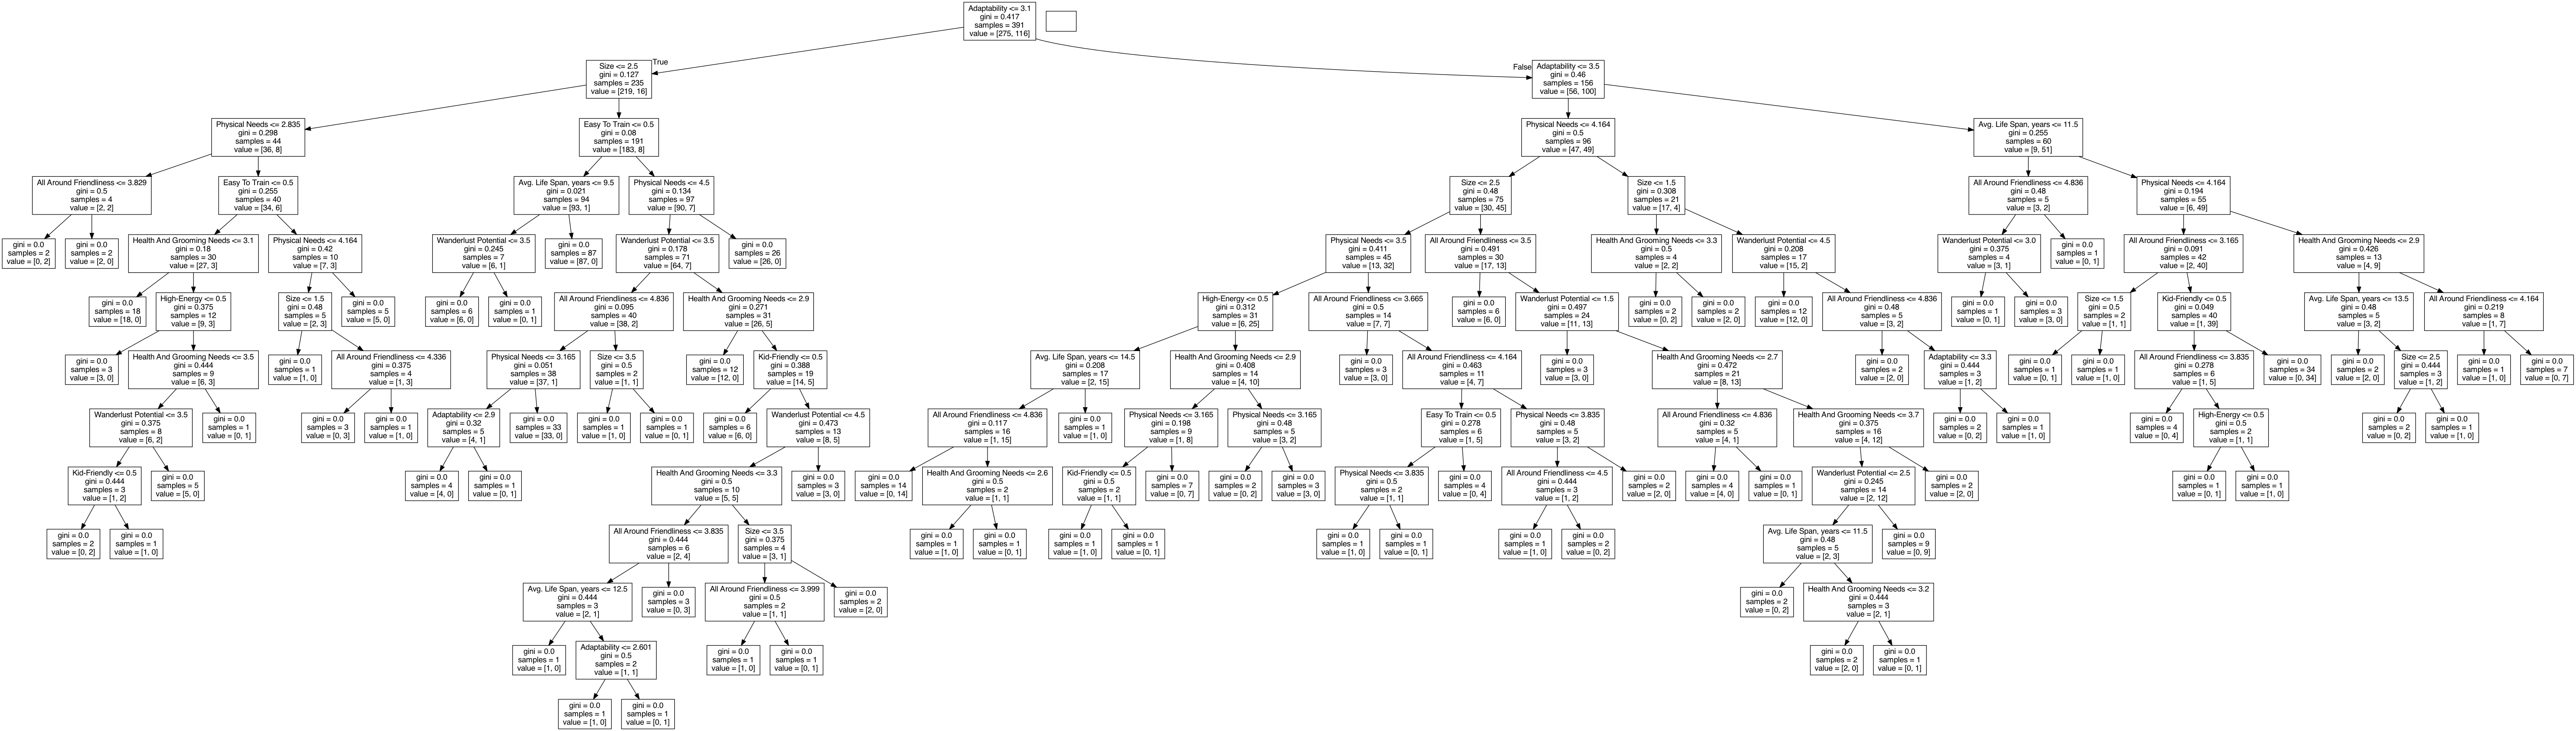

In [17]:
# graph dt1 (ccp_alpha = 0.001)
dot_data = StringIO()

export_graphviz(dt1, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

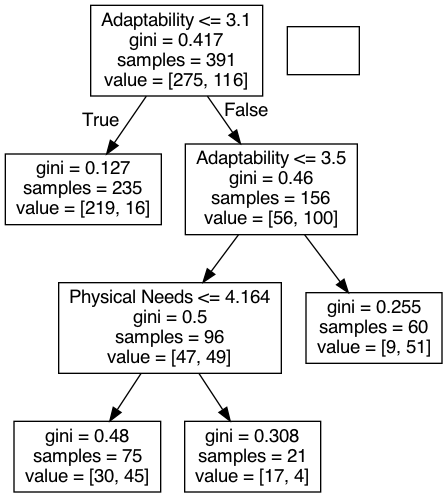

In [18]:
# graph dt2 (ccp_alpha = 0.01)
dot_data = StringIO()

export_graphviz(dt2, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

In [19]:
np.sum(out_class)

116.0

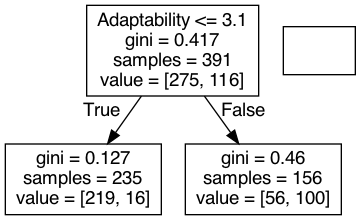

In [20]:
# graph dt3 (ccp_alpha = 0.1)
dot_data = StringIO()

export_graphviz(dt3, out_file=dot_data, feature_names=var_names)
(dt_vis, ) = graph_from_dot_data(dot_data.getvalue())

Image(dt_vis.create_png())

**Question:** Which tree is overfit to the data? Which tree is underfit? What amount of pruning is about right for this dataset?

**Your Thoughts Here**

## Building a Random Forest

Now that we have developed more intuition about (1) taking a majority vote of multiple trees, (2) deciding among a random subset of our features to build different random trees, and (3) pruning large trees, we are ready to define random forests.

Random forests classify data based on a **majority vote** of a grove of **pruned**, **random** decision trees.

Let's build a grove of three pruned decision trees (pruning with the `ccp_alpha` parameter). We'll ensure we get a slightly different tree for each tree in the grove by setting the `max_features` to consider up 4 random features in each tree.

To learn more about the parameters of `DecisionTreeClassifier`, see the [scikit-learn documentation for decision trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [26]:
# build three trees with the same criteria
seed(2022)
dt1 = DecisionTreeClassifier(max_features = 4, ccp_alpha = 0.01)
dt2 = DecisionTreeClassifier(max_features = 4, ccp_alpha = 0.01)
dt3 = DecisionTreeClassifier(max_features = 4, ccp_alpha = 0.01)

In [27]:
# train all three - due to randomness, will be different trees
dt1.fit(in_dog_data, out_class)
dt2.fit(in_dog_data, out_class)
dt3.fit(in_dog_data, out_class)

DecisionTreeClassifier(ccp_alpha=0.01, max_features=4)

Before we make any predictions, take a moment to remind yourself what we are trying to predict.   

* What does it mean for a prediction to be 0? **Your thoughts**
* What does it mean for a prediction to be 1? **Your thoughts**

In [28]:
# predict for the first ten dogs using the first classifier
dt1.predict(in_dog_data[:10,:])

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float16)

In [29]:
# predict for the first ten dogs using the second classifier
dt2.predict(in_dog_data[:10,:])

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float16)

In [30]:
# predict for the first ten dogs using the third classifier
dt3.predict(in_dog_data[:10,:])

array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0.], dtype=float16)

**Question:** Choose a dog that not all three trees agreed on how to classify. What did each of the three random trees predict as the class for this dog? Based on a majority vote, how would we classify the dog?

**Your Answer Here**

## Random Forests in `sklearn`

Now, we'll build a random forest classifier using `sklearn`.

Here we have a few parameters to unpack: 
* `n_estimators` means the number of trees in your grove
* `max_features` means the number of features that the tree in your grove can use
* `max_depth` means how many layers your trees have

Note that pruning our trees is computationally expensive. When we build whole trees and prune them back, we potentially gain more information on which decisions are useful at many levels of our tree, but at the cost of much slower speed.

If we have enough trees in our grove, it's often worth the tradeoff (of information vs. speed) to restrict the depth of our trees rather than building tall trees and pruning back. In practice, this means that `RandomForestClassifier` does have a `ccp_alpha` parameter to prune the trees, but we usually set a `max_depth` instead.

**Question:** Where, in our prior work for this lab and thinking back to Lab 16, have we performed the equivalent of each of these three parameters?

* `n_estimators`: *(your answer here)*  
* `max_features`: *(your answer here)*
* `max_depth`: Our original stopping condition for our from-scratch decision tree in Lab 16.

We will first specify our random forest model, and then fit the random forest model to our data—very similar to the prior `sklearn` classifiers we have built.

In [31]:
# Specify our model
grove = RandomForestClassifier(n_estimators=10, max_features=3, max_depth=2, random_state=0)

In [32]:
# Fit our model to the data
grove.fit(in_dog_data, out_class)

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=10,
                       random_state=0)

### Inferences from our random forests

We can use our random forest to tell us which features are the most important: 

In [36]:
# each importance in the list corresponds with a feature in the dataset
# higher numbers are more important features
print(list(dog_full_pd.columns[:-1]))
print(grove.feature_importances_)

['Size', 'Avg. Life Span, years', 'Wanderlust Potential', 'Adaptability', 'All Around Friendliness', 'Health And Grooming Needs', 'Physical Needs', 'Easy To Train', 'Kid-Friendly', 'High-Energy']
[0.1059448  0.0058709  0.         0.50331832 0.03901869 0.06744
 0.24426651 0.         0.         0.03414078]


**Question:** What is the most important feature in the dataset? Which features are least important? Does this surprise you?

**Your Thoughts Here**

We can also make predictions for a certain dog (or set of dogs), such as for the Laborador Retriever.

In [33]:
lab_traits = dog_full_pd.loc['Labrador Retriever'][:-1]
## (why do we leave off the last feature?)

lab_traits

Size                            4
Avg. Life Span, years          11
Wanderlust Potential            3
Adaptability                  2.8
All Around Friendliness       5.0
Health And Grooming Needs     4.2
Physical Needs                5.0
Easy To Train                True
Kid-Friendly                 True
High-Energy                  True
Name: Labrador Retriever, dtype: object

In [34]:
grove.predict([lab_traits])
## (why do we need extra brackets around our 1D data?)

array([0.], dtype=float16)

Let's compare this to the true class:

In [35]:
dog_full_pd.loc['Labrador Retriever'][-1]

False

How did our system do for this **one** example? 

**Your thoughts here**

We can also see how well we did on our training set (as an accuracy between 0 and 1). That is, we can see for all dog breeds used to create our random forest how well our model did predicting the correct class. 

In [37]:
grove.score(in_dog_data, out_class)

0.8337595907928389

How well did our system do for the **whole** training set? Given this score, how well do you think it would do on a new dog breed? 

**Your thoughts** 

#### Your turn!

Experiment a bit with `max_feature` and `max_depth` in `RandomForestClassifer` and build a second grove. Fit and evaluate this grove on our data. 

In [ ]:
# Specify our model
grove2 = RandomForestClassifier(n_estimators=10, max_features=??, max_depth=??, random_state=0)

In [ ]:
# Fit our model to the data
grove2.fit(???)

In [ ]:
# Determine the most important features


In [ ]:
# Determine the accuracy on the training set


### Final Thoughts

Similar to Lab 16, you have two choices for how you finish up this lab. To get credit, you only need to do one of the two choices. Note that Choice 2 is the same as in Lab 16. 

If you did **not** answer Choice 2 for Lab 16 (either because you chose Choice 1 or because you skipped Lab 16), please answer Choice 2 in this lab. If you have already answered Choice 2 from Lab 16, please answer Choice 1 in this lab.

#### Option 1 - Final Questions:

To finish up this lab, choose another dog breed from the dataset and then ask `grove2` to `predict` whether the breed is "Good For Novice Owners." Share your dog breed, what `grove2` predicted, and the actual classification. Optionally, if you have experience with this dog breed, share your own thoughts on the breed's classification. Then answer the question: **Do you think that random forests are an improvement over the decision tree from last lab?** Why or why not?

#### Choice 2 - Final Questions:

1. Explain at least one scenario in which use of this classifier could be potentially harmful.
2. Name at least one other scenario where forming decisions via a classifier could be potentially harmful and/or unethical. Explain why.
3. What are some considerations you would want to keep in mind when deciding whether use of a classifier is appropriate in a given scenario?

Share your thoughts in a post on the **#lab17_submission** channel on Slack.

If your have questions from this lab, post them to #lab_questions with the same preamble (i.e. starting with **Lab17**). If you have the same question, please use one of the emoji's to upvote the question. If you would like to answer someone's question, please use the thread function. This will tie your answer to their question. 

#### Resources consulted 

0. [ISLR](https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/6062a083acbfe82c7195b27d/1617076404560/ISLR%2BSeventh%2BPrinting.pdf) Section 8.2
1. [SDS 293 Notes by R. Jordan Crouser](http://www.science.smith.edu/~jcrouser/SDS293/)
2. [Random Forest in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
3. [Decision Tree in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
4. [Post pruning decision trees in sklearn](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)